In [1]:
from pathlib import Path

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from dynamical_systems.continuous import solve_ode
from dynamical_systems.metrics import (
    cosine_similarity as cosine_similarity,
    maximum_mean_discrepancy as maximum_mean_discrepancy,
    mean_squared_error as mean_squared_error,
    sinkhorn_divergence as sinkhorn_divergence,
)
from dynamics_discovery.data import TimeSeriesDataset
from dynamics_discovery.misc import load_experiment
from jaxtyping import Array, Float
from ott.utils import batched_vmap
from tqdm import tqdm


plt.style.use("matplotlib_utils.styles.dash_gridded")
jax.config.update("jax_enable_x64", True)

SYSTEMS = ("lorenz63", "rossler76", "hyperchen05")
DATASET_PATHS = {
    "lorenz63": {"train": "lorenz63_large.hdf5", "test": "lorenz63_large_test.hdf5"},
    "rossler76": {"train": "rossler76_train.hdf5", "test": "rossler76_test.hdf5"},
    "hyperchen05": {"train": "hyperchen05_train.hdf5", "test": "hyperchen05_test.hdf5"},
}
EXP_TYPES_ALL = (
    "vanilla",
    "jacobian",
    "tangent_evolution",
    "neighborhood",
    "normal",
    "proxy_tangent_evolution",
)
EXP_TYPES = (
    "vanilla",
    "jacobian",
    "tangent_evolution",
    # "proxy_tangent_evolution",
    "neighborhood",
)
COLOR_DICT = dict(
    zip(
        EXP_TYPES_ALL,
        ("royalblue", "limegreen", "darkorange", "orangered", "saddlebrown", "purple"),
    )
)
LABEL_DICT = dict(
    zip(
        EXP_TYPES_ALL,
        (
            "Vanilla",
            "Jacobian matching",
            "Tangent Evolution matching",
            "Neighborhood-based (ours)",
            "Normal-based (ours)",
            "Identity (ours)",
        ),
    )
)

datadir = Path("../../data")

In [2]:
@eqx.filter_jit
def solve_batch(model, t, u0_batch):
    def _solve(u0_):
        return solve_ode(model, t, u0_, rtol=1e-4, atol=1e-6, max_steps=None)

    return batched_vmap(_solve, batch_size=5000)(u0_batch)


def root_mean_square_error(
    x_true: Float[Array, "batch time dim"],
    x_pred: Float[Array, "batch time dim"],
) -> Float[Array, " time"]:
    """
    Compute cosine similarity between two batches of points along an axis.

    The shapes of the two input arrays must be identical at axis dimension
    and broadcastable along all other dimensions.
    """
    return jnp.mean(jnp.sqrt(jnp.mean((x_true - x_pred) ** 2, axis=-1)), axis=0)


def valid_prediction_time(
    t: Float[Array, " time"],
    x_true: Float[Array, "batch time dim"],
    x_pred: Float[Array, "batch time dim"],
    epsilon: float = 0.2,
):
    rmse: Float[Array, " time"] = root_mean_square_error(x_true, x_pred)
    return t[jnp.argmax(rmse >= epsilon)]

In [3]:
downsample = 2
system_dict = dict()
for system in SYSTEMS:
    _, transform = (
        TimeSeriesDataset.from_hdf5(datadir / DATASET_PATHS[system]["train"])
        .downsample(downsample)
        .add_noise(0.0)
        .standardize()
    )
    dataset_test = (
        TimeSeriesDataset.from_hdf5(datadir / DATASET_PATHS[system]["test"])
        .add_noise(0.0)
        .apply_transform(transform)
    )

    n_short = 750
    t_short = dataset_test.t[0, :n_short]
    u_short_batch = dataset_test.u[:, :n_short]
    del dataset_test
    t_short_norm = np.arange(n_short) * 0.01
    exp_dict = dict()
    for exp_type in tqdm(("vanilla", "tangent_evolution", "neighborhood")):
        vpt = []
        for key in (0, 10, 20, 30, 40):
            model = load_experiment(
                exp_type,
                key,
                downsample,
                2,
                0.0,
                rootdir=Path(f"../../results/best/{system}"),
            )
            u_pred_batch = solve_batch(model, t_short, u_short_batch[:, 0])
            vpt.append(valid_prediction_time(t_short_norm, u_short_batch, u_pred_batch))
        exp_dict[exp_type] = np.asarray(vpt)
    system_dict[system] = exp_dict

100%|██████████| 3/3 [00:31<00:00, 10.65s/it]


In [ ]:
# for k, v in system_dict.items():
#     savepath = Path(f"../../results_analysis/{k}/valid_prediction_time.npz")
#     savepath.parent.mkdir(parents=True, exist_ok=True)
#     np.savez(savepath, v)

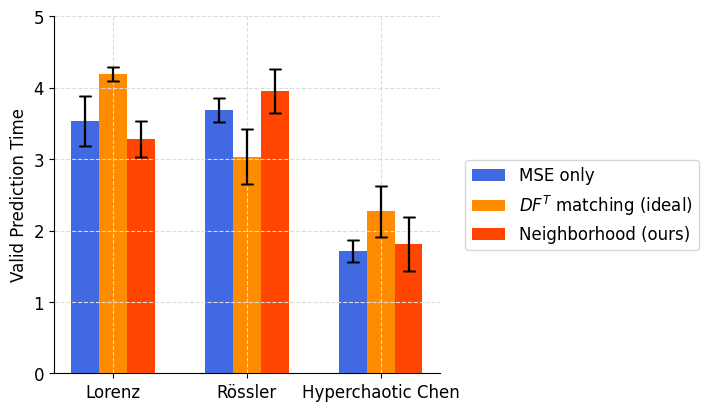

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
x = np.arange(3) * 1.2
width = 0.25
LABEL_DICT = {
    "vanilla": "MSE only",
    "tangent_evolution": "$DF^T$ matching (ideal)",
    "neighborhood": "Neighborhood (ours)",
}
for s in system_dict.keys():
    for i, (exp_type, label) in enumerate(LABEL_DICT.items()):
        vpt_mean = np.asarray(
            [np.mean(system_dict[s][exp_type]) for s in system_dict.keys()]
        )
        vpt_std = np.asarray(
            [np.std(system_dict[s][exp_type]) for s in system_dict.keys()]
        )

        ax.bar(
            x + i * width,
            vpt_mean,
            width,
            yerr=vpt_std,
            label=label,
            color=COLOR_DICT[exp_type],
            capsize=4,
        )
ax.set_xticks(x + width, ["Lorenz", "Rössler", "Hyperchaotic Chen"])
ax.set_ylabel("Valid Prediction Time")
ax.set_ylim((0.0, 5.0))
patches, labels = ax.get_legend_handles_labels()
fig.legend(patches[:3], labels[:3], loc="outside center right", fontsize="medium")

In [6]:
fig.savefig("../../figures/valid_prediction_times.pdf", dpi=1200)